In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [3]:
import numpy as np
import cv2
import tarfile
from pathlib import Path
from tqdm import tqdm
import shutil
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers as tfl
from tensorflow.keras.layers import *
from tensorflow_addons.image import transform as H_transform
import matplotlib.pyplot as plt
import os, datetime

from models.utils import shared_encoder, detector_head, descriptor_head, detector_loss, descriptor_loss, model_metrics, box_nms
from utils.tools import dict_update

In [4]:
!pwd

/root/Internship-Valeo/Project


In [5]:
DATA_PATH = '/root/Internship-Valeo/Project/data'

In [6]:
from datasets import synthetic_dataset
from datasets.utils import pipeline
from datasets.utils.pipeline import parse_primitives
from datasets.utils import photometric_augmentation as photaug
from models.homographies import (sample_homography, compute_valid_mask,
                                            warp_points, filter_points)

In [7]:
default_config = {
        'labels': None,
        'cache_in_memory': False,
        'validation_size': 100,
        'truncate': None,
        'preprocessing': {
            'resize': [240, 320]
        },
        'num_parallel_calls': 10,
        'augmentation': {
            'photometric': {
                'enable': False,
                'primitives': 'all',
                'params': {},
                'random_order': True,
            },
            'homographic': {
                'enable': False,
                'params': {},
                'valid_border_margin': 0,
            },
        },
        'warped_pair': {
            'enable': False,
            'params': {},
            'valid_border_margin': 0,
        },
    }

In [8]:
import yaml
with open('/root/Internship-Valeo/Project/configs/superpoint_coco.yaml', 'r') as stream:
    config = yaml.safe_load(stream)

In [9]:
config1 = config
config = dict_update(default_config, config['data'])

In [10]:
 default_model_config = {
            'data_format': 'channels_first',
            'grid_size': 8,
            'detection_threshold': 0.4,
            'descriptor_size': 256,
            'batch_size': 32,
            'learning_rate': 0.001,
            'lambda_d': 250,
            'descriptor_size': 256,
            'positive_margin': 1,
            'negative_margin': 0.2,
            'lambda_loss': 0.0001,
            'nms': 0,
            'top_k': 0,
    }

In [11]:
model_config = dict_update(default_model_config, config1['model'])

In [12]:
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [13]:
# from datasets import coco
# data = coco.Coco()
# files = data._init_dataset(**config)
# train_gen = data._get_data(files, 'training', **config)
# val_gen = data._get_data(files, 'validation', **config)

In [14]:
# code for photometric augmentation

primitives_photo = parse_primitives(config['augmentation']['photometric']['primitives'], photaug.augmentations)

prim_configs = [config['augmentation']['photometric']['params'].get(p, {}) for p in primitives_photo]

indices = tf.range(len(primitives_photo))
if config['augmentation']['photometric']['random_order']:
    indices = tf.random.shuffle(indices)
def photo_aug_step(i, image):
    fn_pairs = [(tf.equal(indices[i], j), lambda p=p, c=c: getattr(photaug, p)(image, **c))
                for j, (p, c) in enumerate(zip(primitives_photo, prim_configs))]
    image = tf.case(fn_pairs)
    return i + 1, image

In [15]:
# read keypoints
def _read_points(filename):
    print(filename)
    np.load(filename)['points'].astype(np.float32)
#     return np.load(filename).astype(np.float32)

In [16]:
class DataGen(keras.utils.Sequence):
    def __init__(self, image_path, point_path, #homography_path, 
#                  warped_image_path, warped_point_path, 
                 image_size_x = 320, image_size_y = 240,
                 is_training = True, batch_size = model_config['batch_size']):
        
        self.__ids = os.listdir(image_path)
        self.__image_path = image_path
        self.__point_path = point_path
#         self.__homography_path = homography_path
        
#         self.__warped_image_path = warped_image_path
#         self.__warped_point_path = warped_point_path
        
        self.__image_size_x = image_size_x
        self.__image_size_y = image_size_y
        self.__batch_size = batch_size
        self.__is_training = is_training
        self.on_epoch_end()
        
    def __getitem__(self, index):
        images = []
        points_maps = []
        points_list = []
        
        homography_list = []
        
        warped_images = []
        warped_points_maps = []
        warped_points_list = []
        
        valid_masks = []
        
        if (index + 1)*self.__batch_size > len(self.__ids):
            self.__batch_size = len(self.__ids) - index * self.__batch_size
            
        file_batch = self.__ids[index * self.__batch_size : (index + 1) * self.__batch_size]
        
        for id_name in file_batch:
            img_file = os.path.join(self.__image_path, id_name)
            image = cv2.imread(img_file, 0)
            image = cv2.resize(image , (self.__image_size_x , self.__image_size_y))
            image = np.expand_dims(image, axis = 2)
            image_shape = tf.shape(image)[:2]
            
            id_name = id_name.replace('.jpg','')
            
#             point_file = os.path.join(self.__point_path, id_name)
            point_file = os.path.join(self.__point_path,'{}.npz'.format(id_name))
            points = _read_points(point_file)
            print(points)
#             points = np.round(points).astype(int)
    
            
            if self.__is_training:
                # add photometric_augmentation
                _, image = tf.while_loop(lambda i, image: tf.less(i, len(primitives_photo)),
                                 photo_aug_step, [0, image], parallel_iterations=1)              
                
                # read homography file
#                 homography_file = os.path.join(self.__homography_path, id_name+'.npy')
#                 homography = _read_points(homography_file)
                homography = sample_homography(image_shape, config['warped_pair']['params'])[0]
                
                # read warped image
#                 warped_img_file = os.path.join(self.__warped_image_path,id_name)
#                 warped_image = cv2.imread(warped_img_file, 0)        
                warped_image = H_transform(image, homography, interpolation='BILINEAR')
                # compute valid mask
                valid_mask = compute_valid_mask(image_shape, homography,
                                         config['warped_pair']['valid_border_margin'])
                
                # read warped points
#                 warped_point_file = os.path.join(self.__warped_point_path,id_name+'.npy')
#                 warped_points = _read_points(warped_point_file)
                warped_points = warp_points(points, homography)
                warped_points = filter_points(warped_points, image_shape)
#                 warped_points = np.round(warped_points).astype(int)
    
                warped_kp = tf.minimum(warped_points, image_shape-1)
                warped_points_map = tf.scatter_nd(warped_kp, tf.ones([tf.shape(warped_kp)[0]], 
                                                                     dtype=tf.int32), image_shape)
                        
                
                homography_list.append(homography)
                warped_image = warped_image / 255.0
                warped_images.append(warped_image)
                valid_masks.append(valid_mask)
                warped_points_list.append(warped_points)
                warped_points_maps.append(warped_points_map)

            kp = tf.minimum(points, image_shape-1)
            points_map = tf.scatter_nd(kp, tf.ones([tf.shape(kp)[0]], dtype=tf.int32), image_shape)
            
            image = image / 255.0
            images.append(image)
            
            points_maps.append(points_map)
            points_list.append(points)
            
            
            
        images = np.array(images)
        if self.__is_training:
            warped_images = np.array(warped_images)
            homography_list = np.array(homography_list)
            warped_images = np.array(warped_images)
            valid_masks = np.expand_dims(valid_masks, axis = 3)
            dummy_loss_target = np.zeros(self.__batch_size)
            points_maps = np.expand_dims(points_maps, axis = 3)
            warped_points_maps = np.expand_dims(warped_points_maps, axis = 3)
            return [images, 
                    homography_list, 
                    warped_images, 
                    valid_masks, 
                    points_maps,
                    warped_points_maps], [dummy_loss_target, dummy_loss_target, dummy_loss_target]
   
           
    def __len__(self):
        return int(np.ceil(len(self.__ids) / float(self.__batch_size)))
    
    def on_epoch_end(self):
        pass

In [17]:
# from collections import OrderedDict

In [18]:
class HomographyLayer(Layer):
    def call(self, inputs):
        return inputs

def HomographyModel(shape = (8,)):
    x = Input(shape)
    output = HomographyLayer(name="homography_layer", trainable=False)(x)
    return keras.models.Model(inputs = x, outputs = output)

class DescriptorLossLayer(Layer):
    def __init__(self, name='descriptor_loss_layer', trainable=False):
        super(DescriptorLossLayer, self).__init__(name=name)
        self.loss_fn = descriptor_loss
#         self.accuracy_fn = keras.metrics.BinaryAccuracy(name="accuracy")

    def call(self, inputs, targets=None, sample_weight=None):
        loss = model_config['lambda_loss']*self.loss_fn(descriptors = inputs[0], 
                                                        warped_descriptors = inputs[1], 
                                                        homographies = inputs[2], 
                                                        valid_mask = inputs[3], **model_config)
        self.add_loss(loss)
#         return tf.reshape(loss, (1,))
        return loss
#     def compute_output_shape(self, input_shape):
#         return [1]
    
class DetectorLossLayer(Layer):
    def __init__(self, name='detector_loss_layer', trainable=False):
        super(DetectorLossLayer, self).__init__(name=name)
        self.loss_fn = detector_loss
#         self.metrics_fn = model_metrics
#         self.accuracy_fn = keras.metrics.BinaryAccuracy(name="accuracy")

    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(keypoint_map = inputs[0], logits = inputs[1]['logits'], model_config = model_config)
        
#         if model_config['nms']:
#             prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
#                                                min_prob=model_config['detection_threshold'],
#                                                keep_top_k=model_config['top_k']), inputs[1]['prob'])
#         pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.float32)
        
#         metrics = self.metrics_fn(inputs[0], pred)
        self.add_loss(loss)
#         self.add_metric(metrics['precision'], name = 'precision')
#         self.add_metric(metrics['recall'], name = 'recall')
        return loss
#     def compute_output_shape(self, input_shape):
#         return [1]

class WarpedDetectorLossLayer(Layer):
    def __init__(self, name='warped_detector_loss_layer', trainable=False):
        super(WarpedDetectorLossLayer, self).__init__(name=name)
        self.loss_fn = detector_loss
#         self.metrics_fn = model_metrics
#         self.accuracy_fn = keras.metrics.BinaryAccuracy(name="accuracy")

    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(keypoint_map = inputs[0], logits = inputs[1]['logits'], 
                            valid_mask = inputs[2], model_config = model_config)
#         if model_config['nms']:
#             prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
#                                                min_prob=model_config['detection_threshold'],
#                                                keep_top_k=model_config['top_k']), inputs[1]['prob'])
#         pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.float32)
        
#         metrics = self.metrics_fn(inputs[0], pred, valid_mask = inputs[2])
        self.add_loss(loss)
#         self.add_metric(metrics['precision'], name = 'precision')
#         self.add_metric(metrics['recall'], name = 'recall')
        return loss
#     def compute_output_shape(self, input_shape):
#         return [1]
    
def net():
#     inputs = {'image':Input(shape = (240, 320, 1), name = 'image'),
# #               'name': Input(shape = (None,1), name = 'name'),
#               'keypoints':Input(shape = (240,320), name = 'keypoints'),              
#               'valid_mask':Input(shape = (240,320), name = 'valid_mask'),
#               'warped':{
#                   'image':Input(shape = (240, 320, 1), name = 'warped_image'),
# #                   'name': Input(shape = (None,1), name = 'warped_name'),
#                   'keypoints':Input(shape = (240, 320), name = 'warped_keypoints'),
#                   'valid_mask':Input(shape = (240, 320), name = 'warped_valid_mask'),
#                   'homography':Input(shape = (8,), name = 'homography'),
#                }}

#     inputs = OrderedDict((('image',Input(shape = (240, 320, 1), name = 'image')),
#               ('name', Input(shape = (), name = 'name')),
#               ('keypoints',Input(shape = (240,320), name = 'keypoints')),              
#               ('valid_mask',Input(shape = (240,320), name = 'valid_mask')),
#               ('warped',OrderedDict((
#                   ('image',Input(shape = (240, 320, 1), name = 'warped_image')),
#                   ('name', Input(shape = (), name = 'warped_name')),
#                   ('keypoints',Input(shape = (240, 320), name = 'warped_keypoints')),
#                   ('valid_mask',Input(shape = (240, 320), name = 'warped_valid_mask')),
#                   ('homography',Input(shape = (8,), name = 'homography')),))
#               )))

    images_input = Input(shape = (240, 320,1), name = 'image')
    points_maps_input = Input(shape = (240, 320), name = 'keypoints')
    homography_list_input = Input(shape = (8,), name = 'homography') 
    warped_images_input = Input(shape = (240, 320, 1), name = 'warped_image')

    valid_masks_input = Input(shape = (240, 320), name = 'warped_valid_mask')
    warped_points_maps_input = Input(shape = (240, 320), name = 'warped_keypoints')
    
    if model_config['data_format'] == 'channels_first':
        images_input1 = tf.transpose(images_input, [0, 3, 1, 2])
#         images_input1 = tf.transpose(inputs['image'], [0, 3, 1, 2])
        warped_images_input1 = tf.transpose(warped_images_input, [0, 3, 1, 2])
#         warped_images_input1 = tf.transpose(inputs['warped']['image'], [0, 3, 1, 2])
    homography_model = HomographyModel()
    homography = homography_model(homography_list_input)
#     homography = homography_model(inputs['warped']['homography'])
    
    encoder = shared_encoder(shape = (1, 240, 320), model_config = model_config)
    encoder_output = encoder(images_input1)
    warped_encoder_output = encoder(warped_images_input1)
    
    detector = detector_head(shape= (128, 30, 40), model_config = model_config)
    detector_output = detector(encoder_output)
    warped_detector_output = detector(warped_encoder_output)
    
    descriptor = descriptor_head(shape= (128, 30, 40), model_config=model_config)
    descriptor_output = descriptor(encoder_output)
    warped_descriptor_output = descriptor(warped_encoder_output)
    
    if model_config['data_format'] == 'channels_first':
        detector_output['logits'] = tf.transpose(detector_output['logits'], [0, 3, 1, 2])
        warped_detector_output['logits'] = tf.transpose(warped_detector_output['logits'], [0, 3, 1, 2])
        descriptor_output['descriptors_raw'] = tf.transpose(descriptor_output['descriptors_raw'], [0, 3, 1, 2])
        warped_descriptor_output['descriptors_raw'] = tf.transpose(warped_descriptor_output['descriptors_raw'], [0, 3, 1, 2])

    detector_loss_layer = DetectorLossLayer()([points_maps_input, detector_output])
#     detector_loss_layer = DetectorLossLayer()([inputs['keypoints'], detector_output])
    warped_detector_loss_layer = WarpedDetectorLossLayer()([warped_points_maps_input, 
                                                warped_detector_output, 
                                                      valid_masks_input])
#     warped_detector_loss_layer = WarpedDetectorLossLayer()([inputs['warped']['keypoints'], 
#                                                 warped_detector_output, 
#                                                       inputs['warped']['valid_mask']])
    
    descriptor_loss_layer = DescriptorLossLayer()([descriptor_output['descriptors_raw'],
                                                   warped_descriptor_output['descriptors_raw'], 
                                          homography, valid_masks_input])
#     descriptor_loss_layer = DescriptorLossLayer()([descriptor_output['descriptors_raw'],
#                                                    warped_descriptor_output['descriptors_raw'], 
#                                           inputs['warped']['homography'], inputs['warped']['valid_mask']])
    model = keras.models.Model(inputs = [images_input, homography_list_input, 
                                         warped_images_input, 
                                         valid_masks_input, 
                                         points_maps_input, warped_points_maps_input],
                                        
                               outputs = [detector_loss_layer, warped_detector_loss_layer, 
                                          descriptor_loss_layer])
    return model

In [19]:
model = net()

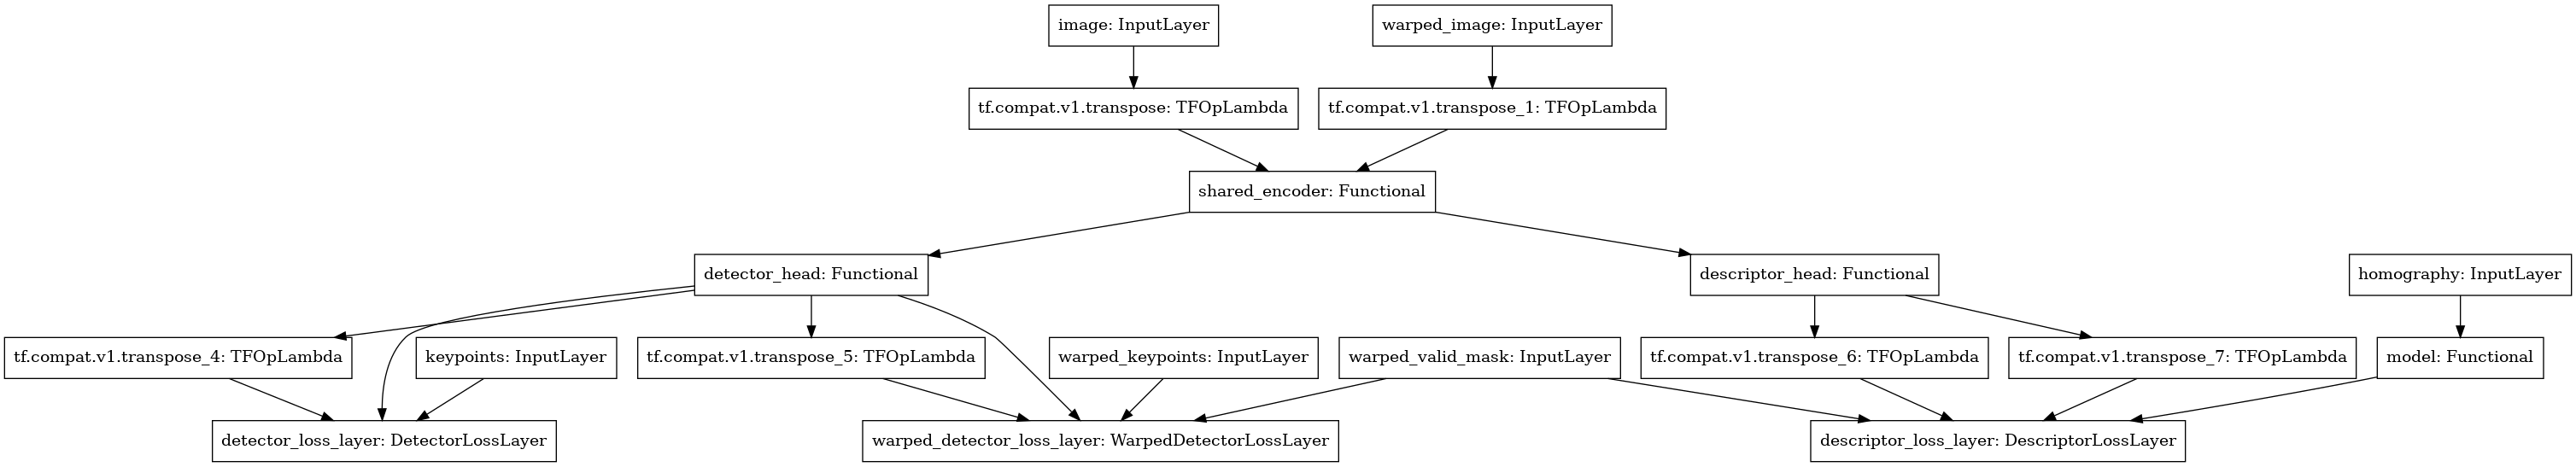

In [20]:
# model.summary()
keras.utils.plot_model(model, to_file="model.png", show_shapes=False, show_dtype=False, show_layer_names=True,
    rankdir="TB", expand_nested=False, dpi=96)

In [21]:
def detect_loss(dummy_target, y_pred):
#     return tf.squeeze(y_pred)
    return y_pred

def descript_loss(dummy_target, y_pred):
#     return tf.squeeze(y_pred)
    return y_pred

def dummy_metrics(dummy_target, y_pred):
#     return tf.squeeze(y_pred)
    return y_pred

def dummy_metrics1(dummy_target, y_pred):
#     return tf.squeeze(y_pred)
    return y_pred

model.compile(optimizer = keras.optimizers.Adam(learning_rate = model_config['learning_rate']),
              loss = [detect_loss,detect_loss, descript_loss],
             loss_weights=[1., 1., 1.])
#                        metrics = [model_metrics, dummy_metrics, dummy_metrics1])

In [22]:
# model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
#         # Path where to save the model
#         # The two parameters below mean that we will overwrite
#         # the current checkpoint if and only if
#         # the `val_loss` score has improved.
#         # The saved model name will include the current epoch.
#         filepath="/root/Internship-Valeo/Project/results/superpoint050222_{epoch}",
#         save_best_only=True,  # Only save a model if `val_loss` has improved.
#         monitor="val_loss",
#         verbose=1,)

# TerminateOnNaN = tf.keras.callbacks.TerminateOnNaN()

In [23]:
image_path_train = '/root/Internship-Valeo/Project/data/COCO/anntrain2014'
point_path_train = '/root/Internship-Valeo/Project/data/COCO/magic_point-coco-export/pointstrain2014'
# homography_path_train = '/root/Internship-Valeo/Project/data/COCO/homographies_train'

# warped_image_path_train = '/root/Internship-Valeo/Project/data/COCO/warptrain2014'
# warped_point_path_train = '/root/Internship-Valeo/Project/data/COCO/warped_pointstrain2014'


In [24]:
train_gen = DataGen(image_path = image_path_train, point_path = point_path_train, 
#                    homography_path = homography_path_train,  
#                    warped_image_path = warped_image_path_train, warped_point_path = warped_point_path_train, 
                    
                 image_size_x = 320, image_size_y = 240,
                 is_training = True, batch_size = model_config['batch_size'])


train_steps =  len(os.listdir(image_path_train))/model_config['batch_size']

In [25]:
# image_path_val = '/root/Internship-Valeo/Project/data/COCO/annval2014'
# point_path_val = '/root/Internship-Valeo/Project/data/COCO/pointsval2014'
# homography_path_val = '/root/Internship-Valeo/Project/data/COCO/homographies_val'

# warped_image_path_val = '/root/Internship-Valeo/Project/data/COCO/warpval2014'
# warped_point_path_val = '/root/Internship-Valeo/Project/data/COCO/warped_pointsval2014'

In [26]:
# val_gen = DataGen(image_path = image_path_val, point_path = point_path_val, 
#                    homography_path = homography_path_val, 
#                    warped_image_path = warped_image_path_val, warped_point_path = warped_point_path_val, 
                   
#                  image_size_x = 320, image_size_y = 240,
#                  is_training = True, batch_size = model_config['batch_size'])

In [27]:
# train_image_path = DATA_PATH + '/COCO/anntrain2014'
# # train_gen = train_gen.repeat()
# train_gen = train_gen.batch(model_config['batch_size'])
# val_gen = val_gen.take(config['validation_size'])
# val_gen = val_gen.batch(model_config['eval_batch_size'])

In [28]:
# steps_per_epoch = len(os.listdir(train_image_path))//model_config['batch_size']
# epochs = config1['train_iter']//steps_per_epoch
history = model.fit(train_gen , batch_size = 1, 
                     steps_per_epoch = 1000, epochs=25, 
                    callbacks=[#model_checkpoint_callback, TerminateOnNaN, 
                        tensorboard_callback])

/root/Internship-Valeo/Project/data/COCO/magic_point-coco-export/pointstrain2014/b'COCO_train2014_000000533809'.npz
None


ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [ ]:
# model.save('/root/Internship-Valeo/Project/results/checkpoint-superpoint-coco-14022022-latest')

In [ ]:
# model.load_weights('/root/Internship-Valeo/Project/results/checkpoint-superpoint-coco')

In [ ]:
x,y = train_gen.__getitem__(0)

In [ ]:
x = iter(train_gen).get_next()

In [ ]:
plt.imshow(x['image'], cmap = 'gray')

In [ ]:
plt.imshow(x['warped_image'], cmap = 'gray')

In [ ]:
plt.imshow(x['warped_valid_mask'], cmap = 'gray')

In [ ]:
plt.imshow(x['warped_keypoints'], cmap = 'gray')

In [ ]:
x['homography']

In [ ]:
x[1][0]

In [ ]:
plt.imshow(x[2][0]*255, cmap = 'gray')

In [ ]:
plt.imshow(x[3][0], cmap = 'gray')

In [ ]:
plt.imshow(x[4][0], cmap = 'gray')

In [ ]:
plt.imshow(x[5][0], cmap = 'gray')

In [ ]:
x, y = val_gen.__getitem__(0)

In [ ]:
plt.imshow(x[0][0]*255, cmap = 'gray')

In [ ]:
x[1][0]

In [ ]:
plt.imshow(x[2][0]*255, cmap = 'gray')

In [ ]:
plt.imshow(x[3][0]*255, cmap = 'gray')

In [ ]:
plt.imshow(x[4][0]*255, cmap = 'gray')

In [ ]:
plt.imshow(x[5][0]*255, cmap = 'gray')

In [30]:
np.load(Path('/root/Internship-Valeo/Project/data/COCO/magic_point-coco-export/pointstrain2014/b\'COCO_train2014_000000533809\'.npz'))['points']

array([[  5, 117],
       [  5, 271],
       [  6, 134],
       [  8, 224],
       [  9, 130],
       [ 10, 155],
       [ 15, 160],
       [ 15, 175],
       [ 17, 270],
       [ 18, 183],
       [ 20, 263],
       [ 21, 201],
       [ 21, 304],
       [ 22, 196],
       [ 25, 217],
       [ 26, 287],
       [ 29,  21],
       [ 30, 316],
       [ 32, 286],
       [ 33, 208],
       [ 34, 216],
       [ 35, 189],
       [ 36, 165],
       [ 37, 136],
       [ 38,  96],
       [ 38, 115],
       [ 38, 287],
       [ 39, 109],
       [ 39, 252],
       [ 40,  81],
       [ 41,  31],
       [ 41,  54],
       [ 42,  14],
       [ 42, 206],
       [ 42, 214],
       [ 43,  27],
       [ 44, 192],
       [ 45, 216],
       [ 46, 260],
       [ 46, 280],
       [ 47, 190],
       [ 48, 230],
       [ 48, 270],
       [ 50,  30],
       [ 51,  23],
       [ 52, 215],
       [ 52, 242],
       [ 53, 221],
       [ 54, 164],
       [ 56, 278],
       [ 57, 184],
       [ 57, 230],
       [ 58,